In [1]:
#Load-in required packages and data
import os
os.chdir("E:/Projects/prediction")
import numpy as np
import pandas as pd
import random
import pycaret
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.preprocessing import label_binarize
data_gz = pd.read_excel("data_all.xlsx",sheet_name = "2_Microbiome_Guangzhou",header = None)
data_eu_gz = pd.read_excel("data_all.xlsx",sheet_name = "3_Microbiome_Euro_Guangzhou",header = None)
data_multi_gz = pd.read_excel("data_all.xlsx",sheet_name = "4_Multiomic_Guangzhou",header = None)

In [2]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,precision_score,recall_score

def stat_table(y_true,y_pred,pos_label):
    Accu = accuracy_score(y_true, y_pred)
    Recall = recall_score(y_true, y_pred, pos_label = pos_label)
    Prec = precision_score(y_true, y_pred, pos_label = pos_label)
    result = pd.DataFrame({'Accuracy':[Accu],'Recall':[Recall],'Precision':[Prec]})
    return result

### 绘制 micro-roc 曲线
def acu_curve(y_test,prob,classes,tab):
    y = label_binarize(y_test, classes=classes)
    y = np.hstack((1-y,y))
    fpr,tpr,threshold = roc_curve(y.ravel(),prob.ravel()) ###计算真正率和假正率
    a = np.transpose([tpr,fpr])
    ap = pd.DataFrame(a)
    ap.columns = ['TPR','FPR']
    ap.to_csv(tab+classes[1]+'.csv',index=False)
    roc_auc = auc(fpr,tpr) ###计算auc的值
 
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='lightcoral',
             lw=lw, label='ROC curve (area = %0.3f)' % roc_auc) ###假正率为横坐标，真正率为纵坐标做曲线
    plt.plot([0, 1], [0, 1], color='mediumaquamarine', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.savefig(tab+classes[1]+'.pdf')
 
    plt.show()

In [3]:
def data_process(data,site):
    colnames = data.iloc[1:,0]
    data = data.drop(index = [0])
    data = data.drop(columns = [0])
    data = data.T
    data.columns = colnames
    if site == True:
        data_new = data.iloc[:,2:].apply(pd.to_numeric, axis=0)
        data_new['Site'] = data['Site']
    else:
        data_new = data.iloc[:,1:].apply(pd.to_numeric, axis=0)
    data_new['FEV1_rate'] = data_new['FEV1_rate'].replace(0,0.000001)
    data_new['FEV1_rate'] = 1/data_new['FEV1_rate']
    data_new['Group'] = data['Group']
    return data_new

In [4]:
data_gz_new = data_process(data_gz,False)
data_eu_gz_new = data_process(data_eu_gz,True)
data_multi_gz_new = data_process(data_multi_gz,False)

# Tab 2 广州数据

In [5]:
### train-test sample splitting
X_train,X_test,y_train,y_test = train_test_split(data_gz_new.drop(axis = 1,columns = ['FEV1_rate','Group']),
                                                 data_gz_new[['FEV1_rate','Group']],test_size = 0.3,random_state = 0)
data_gz_train = pd.concat([X_train,y_train],axis=1)
data_gz_test = pd.concat([X_test,y_test],axis=1)

## regression

In [6]:
from pycaret.regression import *
setup(data_gz_train, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group'],numeric_features = data_gz_train.columns[0:346].tolist(),silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,28.2010,2121.6780,34.1450,-92.1664,0.9196,1.2397,0.1700
rf,Random Forest Regressor,26.2178,1557.6689,31.1849,-318.6149,0.9841,1.3784,0.1480
ada,AdaBoost Regressor,27.7924,1821.8532,34.4084,-331.2257,0.9755,1.4963,0.0600
dt,Decision Tree Regressor,25.7118,1553.4857,28.6012,-943.5038,0.8979,1.6624,0.0130
xgboost,Extreme Gradient Boosting,28.3999,2170.2794,34.7467,-977.1381,1.1956,1.4490,0.1750
gbr,Gradient Boosting Regressor,22.2079,1167.5645,25.4969,-1726.4058,1.0154,1.1590,0.0400
knn,K Neighbors Regressor,32.3825,2139.7919,37.4760,-2179.5969,1.3612,1.7562,0.0130
en,Elastic Net,31.0170,2016.3053,36.9699,-5007.8212,0.9900,1.4811,0.0110
ridge,Ridge Regression,32.7004,2014.7303,38.9376,-6996.1322,1.2575,1.8987,0.0100
lr,Linear Regression,32.8249,2025.2835,39.1224,-7154.3497,1.2733,1.9237,0.5290


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [7]:
ada_reg = create_model('ada')
ada_reg_final = finalize_model(ada_reg)
tuned_ada = tune_model(ada_reg_final)
pred_ada = predict_model(tuned_ada,data = data_gz_test)['Label']
pred_ada_train = predict_model(tuned_ada,data = data_gz_train)['Label']
data_gz_test['FEV1_rate'] = pred_ada
data_gz_train['FEV1_rate'] = pred_ada_train

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,4.7050,33.9794,5.8292,-0.0399,0.4353,0.3525
1,12.6339,202.5855,14.2333,-1.1836,0.4667,1.1897
2,2.4487,6.0063,2.4508,-481.0053,0.2382,0.2319
3,57.4273,4035.9947,63.5295,-1.4633,1.5881,1.6779
4,15.4957,326.5357,18.0703,-1.0397,0.6303,1.2538
5,55.1859,5215.3064,72.2171,-0.1514,1.7607,2.7113
6,6.1941,62.3043,7.8933,-0.4385,0.6355,0.4929
7,64.7694,5552.5584,74.5155,-1.3736,2.0550,1.5355
8,15.7040,287.2357,16.9480,0.9418,0.3810,1.0382
9,3.8251,15.7370,3.9670,-211.4362,0.5864,0.9868


## Classification

### RD vs NonRD

In [8]:
from pycaret.classification import *
data_RD_train = data_gz_train.replace(["Slow_Decliner","Sustainer"],"NonRD")
data_RD_test = data_gz_test.replace(["Slow_Decliner","Sustainer"],"NonRD")
RD_group = setup(data_RD_train,target = "Group", session_id = 43,numeric_features = data_gz_train.columns[0:347].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7667,0.4000,0.0000,0.0000,0.0000,nan,0.0000,0.0170
knn,K Neighbors Classifier,0.7667,0.5250,0.0000,0.0000,0.0000,nan,0.0000,0.0180
ridge,Ridge Classifier,0.7667,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0100
rf,Random Forest Classifier,0.7667,0.4000,0.0000,0.0000,0.0000,nan,0.0000,0.1970
ada,Ada Boost Classifier,0.7667,0.5000,0.2000,0.2000,0.2000,nan,0.1000,0.0640
et,Extra Trees Classifier,0.7667,0.4000,0.0000,0.0000,0.0000,nan,0.0000,0.1340
lightgbm,Light Gradient Boosting Machine,0.7667,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.0230
nb,Naive Bayes,0.7333,0.3500,0.1000,0.1000,0.1000,nan,0.0000,0.0110
lda,Linear Discriminant Analysis,0.7333,0.4000,0.2000,0.1500,0.1667,nan,0.1000,0.0130
xgboost,Extreme Gradient Boosting,0.7000,0.5000,0.1000,0.0500,0.0667,nan,0.0000,0.1070


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=43, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
2,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


<Figure size 432x288 with 0 Axes>

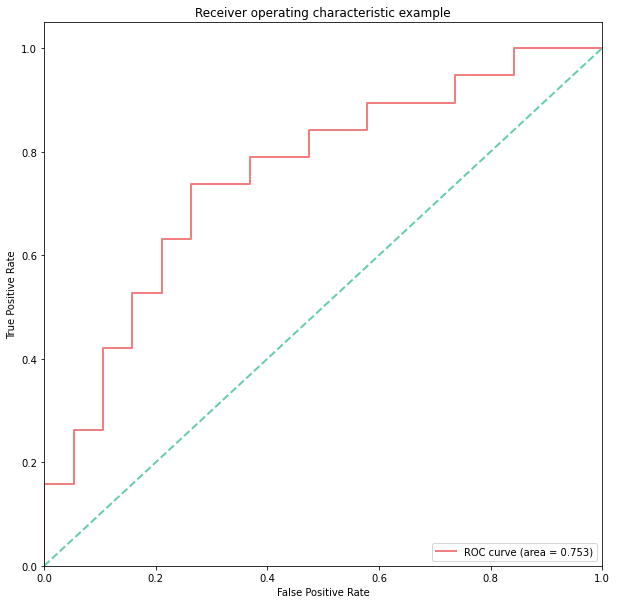

,Accuracy,Recall,Precision
0,0.736842,0.166667,1.0


In [9]:
xgboost_RD = create_model('xgboost')
et_RD = create_model('et')
nb_RD = create_model('nb')
xgboost_RD_final = finalize_model(xgboost_RD)
et_RD_final = finalize_model(et_RD)
nb_RD_final = finalize_model(nb_RD)
blend_RD = blend_models(estimator_list = [xgboost_RD_final,tune_model(et_RD_final),tune_model(nb_RD_final)],method = 'soft')
RD_pred = predict_model(blend_RD,data = data_RD_test)
method_RD = getattr(blend_RD,"predict_proba") ### 获得预测概率，以进行roc曲线的绘制
prob_RD = method_RD(data_RD_test[get_config('X_train').columns])
ROC_RD = acu_curve(data_RD_test['Group'],prob_RD,["NonRD", "Rapid_Decliner"],'Guangzhou_')
stat_table(data_RD_test['Group'],predict_model(blend_RD,data = data_RD_test)['Label'],pos_label = 'Rapid_Decliner')

In [10]:
classes = ["NonRD", "Rapid_Decliner"]

### SD vs NonSD

In [11]:
data_SD_train = data_gz_train.replace(["Rapid_Decliner","Sustainer"],"NonSD")
data_SD_test = data_gz_test.replace(["Rapid_Decliner","Sustainer"],"NonSD")
SD_group = setup(data_SD_train,target = "Group", session_id = 44,numeric_features = data_gz_train.columns[0:347].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.8333,0.8000,0.7500,0.7667,0.7467,0.5900,0.6000,0.0120
gbc,Gradient Boosting Classifier,0.7667,0.7500,0.7000,0.6167,0.6467,0.4900,0.5000,0.0570
ada,Ada Boost Classifier,0.7500,0.8500,0.7000,0.6167,0.6467,0.4900,0.5000,0.0650
xgboost,Extreme Gradient Boosting,0.7000,0.7000,0.5500,0.5500,0.5500,0.3500,0.3500,0.1110
nb,Naive Bayes,0.6500,0.5750,0.4500,0.4000,0.4000,0.2700,0.3000,0.0130
qda,Quadratic Discriminant Analysis,0.6333,0.6000,0.6000,0.5167,0.5467,0.2100,0.2000,0.0120
knn,K Neighbors Classifier,0.5833,0.6750,0.1500,0.2000,0.1667,0.0400,0.0500,0.0180
rf,Random Forest Classifier,0.5833,0.7000,0.2500,0.2500,0.2500,0.0500,0.0500,0.1580
lightgbm,Light Gradient Boosting Machine,0.5833,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0270
lr,Logistic Regression,0.5500,0.5500,0.1500,0.1000,0.1167,-0.0600,-0.0500,0.0180


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=44, splitter='best')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.5000,0.5000,1.0000,0.6667,0.4000,0.5000
1,0.3333,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

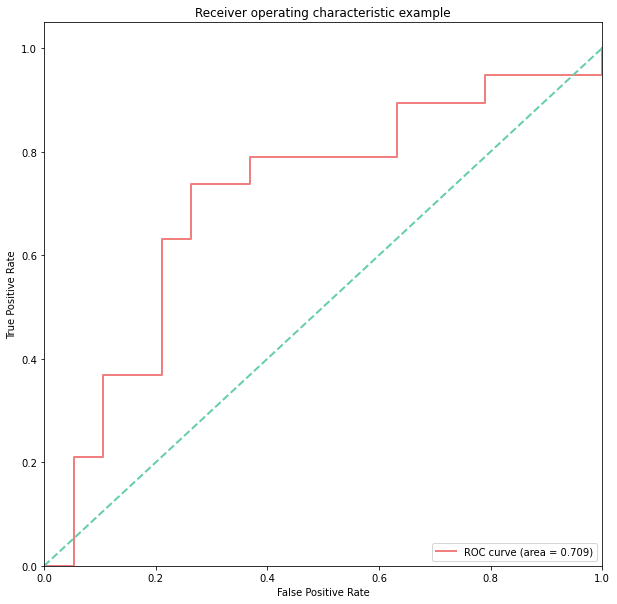

,Accuracy,Recall,Precision
0,0.736842,0.428571,0.75


In [12]:
knn_SD = create_model('knn')
et_SD = create_model('et')
rf_SD = create_model('rf')
knn_SD_final = finalize_model(knn_SD)
et_SD_final = finalize_model(et_SD)
rf_SD_final = finalize_model(rf_SD)
blend_SD = blend_models(estimator_list = [knn_SD_final,et_SD_final,rf_SD_final],method = 'soft')
method_SD = getattr(blend_SD,"predict_proba")
prob_SD = method_SD(data_SD_test[get_config('X_train').columns])
ROC_SD = acu_curve(data_SD_test['Group'],prob_SD,['NonSD','Slow_Decliner'],'Guangzhou_')
stat_table(data_SD_test['Group'],predict_model(blend_SD,data = data_SD_test)['Label'],pos_label = 'Slow_Decliner')

### ST vs NonST

In [13]:
data_ST_train = data_gz_train.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
data_ST_test = data_gz_test.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
ST_group = setup(data_ST_train,target = "Group", session_id = 45,numeric_features = data_gz_train.columns[0:347].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.7667,0.6500,0.5500,0.5000,0.5000,0.4200,0.4500,0.0640
knn,K Neighbors Classifier,0.7333,0.7250,0.6500,0.5500,0.5833,0.3800,0.4000,0.0190
qda,Quadratic Discriminant Analysis,0.7167,0.6750,0.5500,0.5500,0.5500,0.3500,0.3500,0.0120
lr,Logistic Regression,0.6500,0.6500,0.3500,0.2500,0.2833,0.1300,0.1500,0.0160
xgboost,Extreme Gradient Boosting,0.6500,0.7000,0.5500,0.3500,0.4000,0.2400,0.3000,0.1090
ridge,Ridge Classifier,0.6167,0.0000,0.3500,0.2000,0.2500,0.0700,0.1000,0.0110
rf,Random Forest Classifier,0.6167,0.5250,0.2000,0.1500,0.1667,0.0900,0.1000,0.1690
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0220
svm,SVM - Linear Kernel,0.6000,0.0000,0.6500,0.4500,0.5167,0.1800,0.2000,0.0110
dt,Decision Tree Classifier,0.5833,0.5500,0.4500,0.2833,0.3333,0.0800,0.1000,0.0150


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=45)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.3333,0.0000,0.5000,0.5000,0.5000,-0.5000,-0.5000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

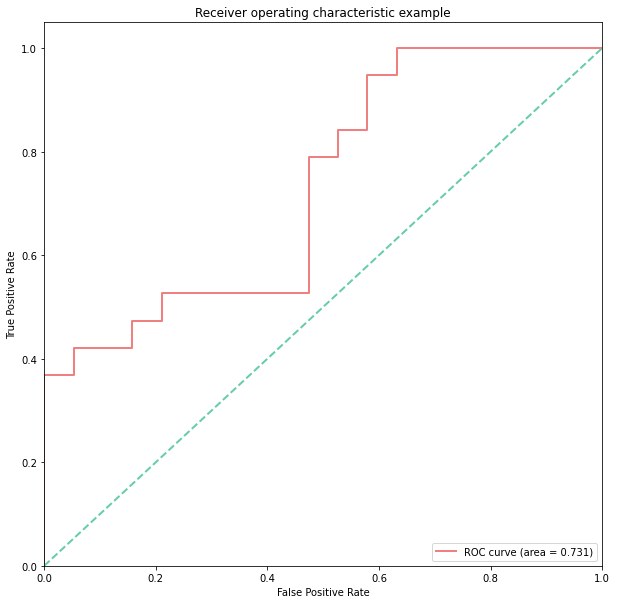

,Accuracy,Recall,Precision
0,0.526316,0.0,0.0


In [14]:
svm_ST_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 45)
svm_ST = create_model(svm_ST_temp)
svm_ST_final = finalize_model(svm_ST)
knn_ST = create_model('knn')
knn_ST_final = finalize_model(knn_ST)
lightgbm_ST = create_model('lightgbm')
lightgbm_ST_final = finalize_model(lightgbm_ST)
blend_ST = blend_models(estimator_list = [svm_ST_final,knn_ST_final,lightgbm_ST_final],method = 'soft')
method_ST = getattr(blend_ST,"predict_proba")
prob_ST = method_ST(data_ST_test[get_config('X_train').columns])
ROC_ST = acu_curve(data_ST_test['Group'],prob_ST,['NonST','Sustainer'],'Guangzhou_')
stat_table(data_ST_test['Group'],predict_model(blend_ST,data = data_ST_test)['Label'],pos_label = 'Sustainer')

# Tab 3 欧洲-广州 交叉验证

In [15]:
data_A = data_eu_gz_new[data_eu_gz_new['Site']=='European']
data_B = data_eu_gz_new[data_eu_gz_new['Site']=='Guangzhou']

## Europe for fitting, guangzhou for prediction

In [16]:
from pycaret.regression import *
setup(data_A, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7, train_size = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group','Site'],silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,854.7273,42734074.2922,2392.6112,-0.2504,1.6854,1.6018,0.0140
par,Passive Aggressive Regressor,843.9985,42302823.9444,2399.0279,-0.3669,1.5082,1.6549,0.0100
huber,Huber Regressor,890.5028,42390118.7650,2449.7444,-0.7784,1.4489,2.1484,0.0250
br,Bayesian Ridge,1183.2433,42546794.0837,2694.9499,-4.3585,1.6821,5.7554,0.0130
lightgbm,Light Gradient Boosting Machine,2026.8661,47090446.2194,3928.4885,-51.7772,2.3321,14.7356,0.0430
en,Elastic Net,2507.2602,48858834.7250,4436.9320,-73.2626,2.5818,18.4424,0.0140
et,Extra Trees Regressor,1758.5526,50782735.3088,4256.8638,-91.2756,2.0421,10.2054,0.1880
rf,Random Forest Regressor,1491.6787,56342136.8458,4294.2476,-149.4754,1.7954,9.6504,0.2380
omp,Orthogonal Matching Pursuit,3206.7633,55642123.1665,5401.1935,-170.0704,2.8261,25.6666,0.0110
ada,AdaBoost Regressor,1359.3862,81282452.4347,4304.5138,-313.5312,1.5005,2.7518,0.0610


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [17]:
reg_knn_A = create_model('knn')
knn_A_final = finalize_model(reg_knn_A)
knn_A = tune_model(knn_A_final)
pred_B = predict_model(knn_A,data = data_B)['Label']
pred_A = predict_model(knn_A,data = data_A)['Label']
data_A_fit = data_A
data_A_fit['FEV1_rate'] = pred_A
data_B_fit = data_B
data_B_fit['FEV1_rate'] = pred_B

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,266.1274,115695.5703,340.1405,0.0705,1.5519,1.0324
1,225.8809,99066.8828,314.7489,-0.8149,1.0872,1.5673
2,422.7866,675487.0625,821.8802,0.0960,1.7870,0.9552
3,244.2572,89882.2188,299.8036,-1.1302,1.7999,1.8844
4,240.3804,90776.1797,301.2909,-0.6968,1.1011,1.9739
5,232.8974,89142.1250,298.5668,-0.1658,1.4994,1.6211
6,284.2152,151838.0469,389.6640,-0.5353,1.2350,1.4675
7,305.5208,139310.2969,373.2430,-0.5825,1.5894,2.0368
8,279.8568,120961.4297,347.7951,-0.6772,2.6555,2.8033
9,6183.3438,428871680.0000,20709.2168,-0.1118,1.6649,1.1607


### RD vs NonRD

In [18]:
from pycaret.classification import *
data_A_RD = data_A_fit.replace(["Slow_decliner","Sustainer"],"NonRD")
data_B_RD = data_B_fit.replace(["Slow_decliner","Sustainer"],"NonRD")
A_RD = setup(data_A_RD,target = "Group", session_id = 43,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7615,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0120
rf,Random Forest Classifier,0.7308,0.4393,0.0000,0.0000,0.0000,-0.0522,-0.0632,0.1690
et,Extra Trees Classifier,0.7141,0.5000,0.0000,0.0000,0.0000,-0.0772,-0.0891,0.1410
gbc,Gradient Boosting Classifier,0.6974,0.4122,0.0333,0.0500,0.0400,-0.0759,-0.0884,0.1210
knn,K Neighbors Classifier,0.6827,0.4202,0.0000,0.0000,0.0000,-0.1123,-0.1190,0.0180
xgboost,Extreme Gradient Boosting,0.6821,0.4419,0.0667,0.0750,0.0686,-0.0765,-0.0943,0.1240
lightgbm,Light Gradient Boosting Machine,0.6667,0.3096,0.0000,0.0000,0.0000,-0.1416,-0.1604,0.0390
dt,Decision Tree Classifier,0.6359,0.4750,0.1667,0.1617,0.1602,-0.0520,-0.0550,0.0120
lr,Logistic Regression,0.6282,0.5452,0.2000,0.1183,0.1480,-0.0610,-0.0639,0.0560
ada,Ada Boost Classifier,0.6244,0.4011,0.0000,0.0000,0.0000,-0.1942,-0.2120,0.0800


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6923,0.6667,0.3333,0.3333,0.3333,0.1333,0.1333
1,0.6923,0.0333,0.0000,0.0000,0.0000,-0.1304,-0.1581
2,0.7692,0.4000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.7692,0.2667,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6923,0.4000,0.0000,0.0000,0.0000,-0.1304,-0.1581
5,0.7692,0.3000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.7500,0.4444,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.7500,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.6667,0.4815,0.0000,0.0000,0.0000,-0.1429,-0.1741
9,0.7500,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

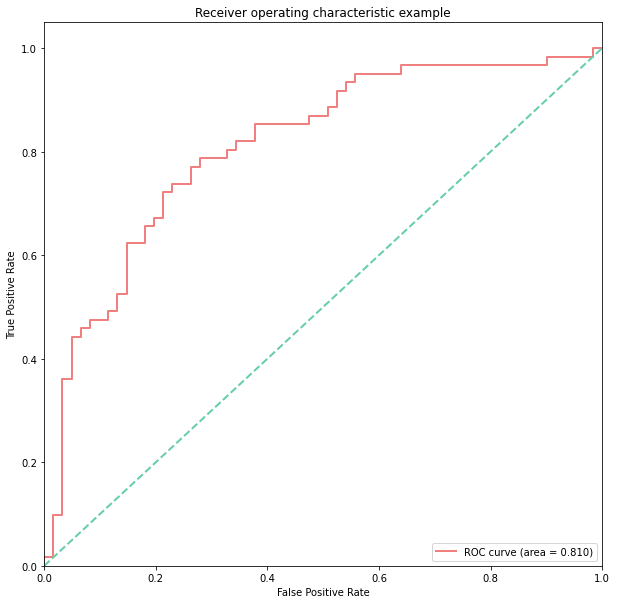

,Accuracy,Recall,Precision
0,0.737705,0.066667,0.333333


In [19]:
svm_A_RD_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 43)
svm_A_RD = create_model(svm_A_RD_temp)
gbm_A_RD = create_model('lightgbm')
lr_A_RD = create_model('lr')
svm_A_RD_final = finalize_model(svm_A_RD)
gbm_A_RD_final = finalize_model(gbm_A_RD)
lr_A_RD_final = finalize_model(lr_A_RD)
blend_A_RD = blend_models(estimator_list = [svm_A_RD_final,gbm_A_RD_final,tune_model(lr_A_RD_final)],method = 'soft')
method_A_RD = getattr(blend_A_RD,"predict_proba")
prob_B_RD = method_A_RD(data_B_RD[get_config('X_train').columns])
ROC_B_RD = acu_curve(data_B_RD['Group'],prob_B_RD,["NonRD", "Rapid_decliner"],tab = 'CV_Guangzhou_')
stat_table(data_B_RD['Group'],predict_model(blend_A_RD,data = data_B_RD)['Label'],pos_label = 'Rapid_decliner')

### SD vs NonSD

In [20]:
data_A_SD = data_A_fit.replace(["Rapid_decliner","Sustainer"],"NonSD")
data_B_SD = data_B_fit.replace(["Rapid_decliner","Sustainer"],"NonSD")
A_SD = setup(data_A_SD,target = "Group", session_id = 44,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.6019,0.5889,0.5500,0.5560,0.5346,0.1951,0.2060,0.0390
knn,K Neighbors Classifier,0.5840,0.6177,0.4667,0.5738,0.4922,0.1451,0.1621,0.0240
xgboost,Extreme Gradient Boosting,0.5673,0.5579,0.4367,0.5527,0.4563,0.1131,0.1356,0.1250
svm,SVM - Linear Kernel,0.5635,0.0000,0.6033,0.4510,0.5103,0.1230,0.1340,0.0090
qda,Quadratic Discriminant Analysis,0.5551,0.5676,0.6567,0.4962,0.5577,0.1287,0.1394,0.0110
gbc,Gradient Boosting Classifier,0.5449,0.5304,0.3800,0.4817,0.4087,0.0568,0.0621,0.1320
nb,Naive Bayes,0.5404,0.6132,0.6600,0.5006,0.5557,0.1107,0.1101,0.0110
rf,Random Forest Classifier,0.5218,0.5187,0.3100,0.3562,0.3157,-0.0069,-0.0260,0.1830
lda,Linear Discriminant Analysis,0.4994,0.5214,0.4567,0.4433,0.4311,-0.0132,-0.0009,0.0110
lr,Logistic Regression,0.4840,0.5242,0.4667,0.4350,0.4254,-0.0260,-0.0092,0.0600


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=44, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6154,0.5750,0.6000,0.5000,0.5455,0.2169,0.2196
1,0.3846,0.4286,0.3333,0.3333,0.3333,-0.2381,-0.2381
2,0.5385,0.4524,0.3333,0.5000,0.4000,0.0488,0.0514
3,0.5385,0.5238,0.1667,0.5000,0.2500,0.0250,0.0329
4,0.6154,0.7143,0.6667,0.5714,0.6154,0.2353,0.2381
5,0.3846,0.4524,0.0000,0.0000,0.0000,-0.3000,-0.3948
6,0.5833,0.6000,0.2000,0.5000,0.2857,0.0625,0.0756
7,0.5000,0.4286,0.6000,0.4286,0.5000,0.0270,0.0286
8,0.3333,0.4571,0.0000,0.0000,0.0000,-0.4545,-0.4880
9,0.2500,0.3143,0.0000,0.0000,0.0000,-0.5882,-0.5976


<Figure size 432x288 with 0 Axes>

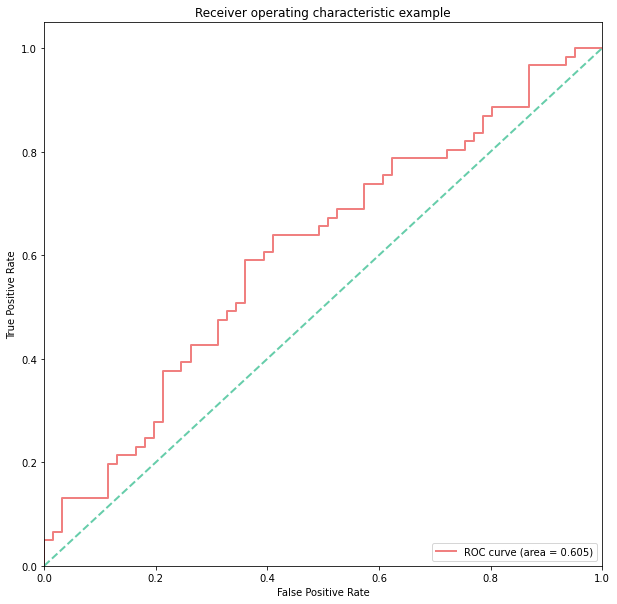

,Accuracy,Recall,Precision
0,0.606557,0.08,0.666667


In [21]:
rf_A_SD = create_model('rf')
et_A_SD = create_model('et')
xgboost_A_SD = create_model('xgboost')
rf_A_SD_final = finalize_model(rf_A_SD)
et_A_SD_final = finalize_model(et_A_SD)
xgboost_A_SD_final = finalize_model(xgboost_A_SD)
blend_A_SD = blend_models(estimator_list = [rf_A_SD_final,et_A_SD_final,tune_model(xgboost_A_SD_final)],method = 'soft')
method_A_SD = getattr(blend_A_SD,"predict_proba")
prob_B_SD = method_A_SD(data_B_SD[get_config('X_train').columns])
ROC_B_SD = acu_curve(data_B_SD['Group'],prob_B_SD,["NonSD", "Slow_decliner"],tab = 'CV_Guangzhou_')
stat_table(data_B_SD['Group'],predict_model(blend_A_SD,data = data_B_SD)['Label'],pos_label = 'Slow_decliner')

### ST vs NonST

In [22]:
data_A_ST = data_A_fit.replace(["Rapid_decliner","Slow_decliner"],"NonST")
data_B_ST = data_B_fit.replace(["Rapid_decliner","Slow_decliner"],"NonST")
A_ST = setup(data_A_ST,target = "Group", session_id = 45,ignore_features = ['Site'],silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.7385,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0130
lightgbm,Light Gradient Boosting Machine,0.7365,0.6237,0.3500,0.4500,0.3829,0.2337,0.2437,0.0460
knn,K Neighbors Classifier,0.7288,0.6471,0.3250,0.4917,0.3643,0.2139,0.2363,0.0200
xgboost,Extreme Gradient Boosting,0.7128,0.6443,0.2417,0.3000,0.2571,0.1183,0.1165,0.1130
rf,Random Forest Classifier,0.7058,0.5329,0.1167,0.2833,0.1567,0.0390,0.0515,0.1640
gbc,Gradient Boosting Classifier,0.6974,0.5554,0.2417,0.3167,0.2719,0.1089,0.1071,0.1270
dt,Decision Tree Classifier,0.6891,0.5789,0.3500,0.3867,0.3560,0.1574,0.1622,0.0110
et,Extra Trees Classifier,0.6821,0.5763,0.1167,0.3200,0.1622,0.0132,0.0306,0.1480
ada,Ada Boost Classifier,0.6410,0.6352,0.3250,0.2667,0.2897,0.0676,0.0666,0.0720
svm,SVM - Linear Kernel,0.6321,0.0000,0.5250,0.3448,0.4094,0.1626,0.1705,0.0090


QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6154,0.8056,0.0000,0.0000,0.0000,-0.1404,-0.1925
1,0.8462,0.7222,0.5000,1.0000,0.6667,0.5806,0.6396
2,0.7692,0.6944,0.2500,1.0000,0.4000,0.3158,0.4330
3,0.8462,0.8333,0.3333,1.0000,0.5000,0.4348,0.5270
4,0.8462,0.5667,0.3333,1.0000,0.5000,0.4348,0.5270
5,0.6154,0.6333,0.0000,0.0000,0.0000,-0.2264,-0.2335
6,0.7500,0.6296,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.5833,0.4815,0.0000,0.0000,0.0000,-0.2500,-0.2582
8,0.7500,0.3333,0.3333,0.5000,0.4000,0.2500,0.2582
9,0.5833,0.5556,0.0000,0.0000,0.0000,-0.2500,-0.2582


<Figure size 432x288 with 0 Axes>

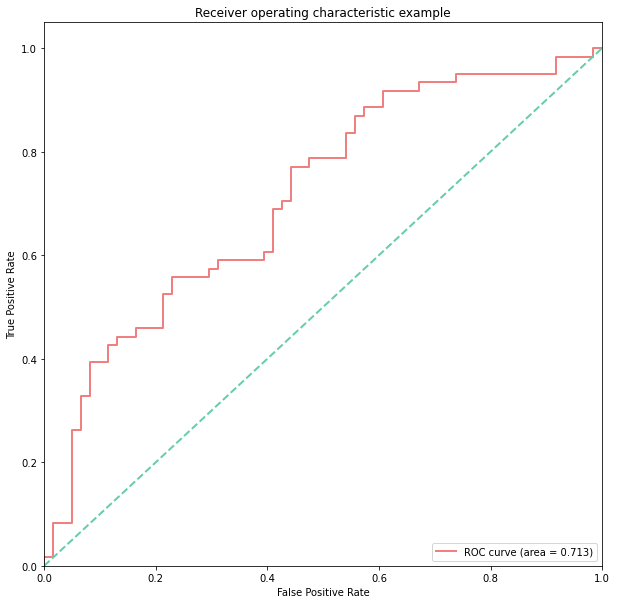

,Accuracy,Recall,Precision
0,0.606557,0.238095,0.384615


In [23]:
ada_A_ST = create_model('ada')
dt_A_ST = create_model('dt')
qda_A_ST = create_model('qda')
ada_A_ST_final = finalize_model(ada_A_ST)
dt_A_ST_final = finalize_model(dt_A_ST)
qda_A_ST_final = finalize_model(qda_A_ST)
blend_A_ST = blend_models(estimator_list = [ada_A_ST_final,dt_A_ST_final,qda_A_ST_final],method = 'soft')
method_A_ST = getattr(blend_A_ST,"predict_proba")
prob_B_ST = method_A_ST(data_B_ST[get_config('X_train').columns])
ROC_B_ST = acu_curve(data_B_ST['Group'],prob_B_ST,["NonST", "Sustainer"],tab = 'CV_Guangzhou_')
stat_table(data_B_ST['Group'],predict_model(blend_A_ST,data = data_B_ST)['Label'],pos_label = 'Sustainer')

# Tab 4 广州多组学数据

In [24]:
cols = data_multi_gz_new.columns
OTUs = [s for s in cols if 'OTU' in s]
Hosts = [s for s in cols if 'Host' in s]
Metas = [s for s in cols if 'MetaB' in s]
data_OTU_Host = pd.concat([data_multi_gz_new[OTUs],data_multi_gz_new[Hosts]],axis=1)
data_OTU_Meta = pd.concat([data_multi_gz_new[OTUs],data_multi_gz_new[Metas]],axis=1)
data_Host_Meta = pd.concat([data_multi_gz_new[Hosts],data_multi_gz_new[Metas]],axis=1)

## 微生物组+转录组数据

In [25]:
### train-test sample splitting
X_train_OH,X_test_OH,y_train_OH,y_test_OH = train_test_split(data_OTU_Host,
                                                 data_multi_gz_new[['FEV1_rate','Group']],test_size = 0.3,random_state = 0)
data_gz_train_OH = pd.concat([X_train_OH,y_train_OH],axis=1)
data_gz_test_OH = pd.concat([X_test_OH,y_test_OH],axis=1)

In [26]:
from pycaret.regression import *
setup(data_gz_train_OH, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group'],numeric_features = data_gz_train_OH.columns[0:515].tolist(),silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,24.7253,1404.6771,30.3486,-0.7696,0.8298,1.1943,0.1740
rf,Random Forest Regressor,23.9417,1270.0123,28.8871,-0.8751,1.0615,1.1081,0.1470
br,Bayesian Ridge,27.2553,1537.6766,32.1647,-1.1807,1.0439,1.3817,0.0170
et,Extra Trees Regressor,26.1653,1193.6936,30.0267,-1.3325,0.9292,1.2545,0.1270
ada,AdaBoost Regressor,25.4799,1412.0622,30.8346,-1.4051,0.9295,1.1601,0.0570
knn,K Neighbors Regressor,27.7012,1490.1428,32.8191,-1.7703,1.0676,1.4194,0.0150
en,Elastic Net,25.5629,1487.9377,31.7242,-2.9754,1.0048,1.2803,0.0120
ridge,Ridge Regression,25.3614,1524.3274,32.0046,-3.5057,1.0736,1.3001,0.0110
lr,Linear Regression,25.4138,1531.1438,32.1176,-3.5760,1.0889,1.3056,0.0110
gbr,Gradient Boosting Regressor,31.9257,1572.8653,36.2493,-3.6864,0.9534,1.6524,0.0440


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [27]:
reg_OH = create_model('lightgbm')
tuned_reg_OH = tune_model(finalize_model(reg_OH))
pred_OH = predict_model(tuned_reg_OH,data = data_gz_test_OH)['Label']
pred_train_OH = predict_model(tuned_reg_OH,data = data_gz_train_OH)['Label']
data_gz_test_OH['FEV1_rate'] = pred_OH
data_gz_train_OH['FEV1_rate'] = pred_train_OH

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.0973,6265.9810,79.1579,-0.0349,1.6121,0.7086
1,45.3889,3712.4433,60.9298,-1.2468,1.6752,0.6313
2,23.6086,1081.5607,32.8871,-0.3498,0.6390,0.7409
3,11.1728,260.7656,16.1482,-0.2427,0.1988,0.8007
4,7.6179,79.3082,8.9055,-0.0013,0.7371,1.0678
5,12.6420,225.6487,15.0216,-2.4278,0.6448,1.6730
6,9.7091,127.8504,11.3071,-2.8069,0.8809,2.3979
7,19.3942,583.1195,24.1479,-0.5503,0.2725,1.0056
8,37.3500,1403.0014,37.4567,-0.0057,0.9638,1.1162
9,17.2727,307.0923,17.5240,-0.0293,0.6732,1.8010


### RD vs NonRD

In [28]:
from pycaret.classification import *
data_RD_train_OH = data_gz_train_OH.replace(["Slow_Decliner","Sustainer"],"NonRD")
data_RD_test_OH = data_gz_test_OH.replace(["Slow_Decliner","Sustainer"],"NonRD")
RD_group_OH = setup(data_RD_train_OH,target = "Group", session_id = 43,
                    numeric_features = data_gz_train_OH.columns[0:515].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8333,0.2000,0.0000,0.0000,0.0000,nan,0.0000,0.0240
knn,K Neighbors Classifier,0.8333,0.3000,0.0000,0.0000,0.0000,nan,0.0000,0.0200
svm,SVM - Linear Kernel,0.8333,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0140
ridge,Ridge Classifier,0.8333,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0110
rf,Random Forest Classifier,0.8333,0.1000,0.0000,0.0000,0.0000,nan,0.0000,0.1660
qda,Quadratic Discriminant Analysis,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0240
et,Extra Trees Classifier,0.8333,0.3000,0.0000,0.0000,0.0000,nan,0.0000,0.1420
lightgbm,Light Gradient Boosting Machine,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0300
lda,Linear Discriminant Analysis,0.8000,0.2000,0.0000,0.0000,0.0000,nan,-0.0500,0.0150
xgboost,Extreme Gradient Boosting,0.8000,0.2000,0.0000,0.0000,0.0000,nan,0.0000,0.1380


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=43, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


<Figure size 432x288 with 0 Axes>

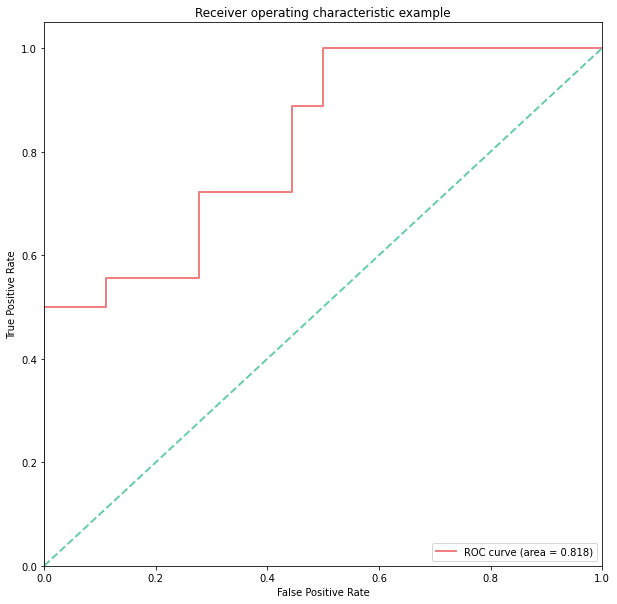

,Accuracy,Recall,Precision
0,0.722222,0.0,0.0


In [29]:
ada_RD_OH = create_model('ada')
knn_RD_OH = create_model('knn')
nb_RD_OH = create_model('nb')
ada_RD_OH_final = finalize_model(ada_RD_OH)
knn_RD_OH_final = finalize_model(knn_RD_OH)
nb_RD_OH_final = finalize_model(nb_RD_OH)
blend_RD_OH = blend_models(estimator_list = [ada_RD_OH_final,knn_RD_OH_final,nb_RD_OH_final],method = 'soft')
RD_OH_pred = predict_model(blend_RD_OH,data = data_RD_test_OH)
method_RD_OH = getattr(blend_RD_OH,"predict_proba") 
prob_RD_OH = method_RD_OH(data_RD_test_OH[get_config('X_train').columns])
ROC_RD_OH = acu_curve(data_RD_test_OH['Group'],prob_RD_OH,["NonRD", "Rapid_Decliner"],'Guangzhou_OTU_HostT_')
stat_table(data_RD_test_OH['Group'],predict_model(blend_RD_OH,data = data_RD_test_OH)['Label'],pos_label = 'Rapid_Decliner')

### SD vs NonSD

In [30]:
data_SD_train_OH = data_gz_train_OH.replace(["Rapid_Decliner","Sustainer"],"NonSD")
data_SD_test_OH = data_gz_test_OH.replace(["Rapid_Decliner","Sustainer"],"NonSD")
SD_group_OH = setup(data_SD_train_OH,target = "Group", session_id = 44,
                    numeric_features = data_gz_train_OH.columns[0:515].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.7833,0.9000,0.6000,0.5500,0.5667,0.4900,0.5000,0.0150
et,Extra Trees Classifier,0.7500,0.8500,0.7000,0.6000,0.6333,0.5000,0.5000,0.1430
rf,Random Forest Classifier,0.7167,0.8500,0.6000,0.5000,0.5333,0.4000,0.4000,0.1580
dt,Decision Tree Classifier,0.6500,0.6250,0.5000,0.4500,0.4667,0.2600,0.2500,0.0150
xgboost,Extreme Gradient Boosting,0.6500,0.8500,0.4000,0.3500,0.3667,0.2100,0.2000,0.1400
qda,Quadratic Discriminant Analysis,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0150
ada,Ada Boost Classifier,0.6167,0.7000,0.6000,0.4000,0.4667,0.2300,0.2500,0.0720
gbc,Gradient Boosting Classifier,0.6167,0.6500,0.5000,0.4000,0.4333,0.2000,0.2000,0.0760
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0310
knn,K Neighbors Classifier,0.5667,0.4000,0.1000,0.1000,0.1000,-0.0500,-0.0500,0.0270


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.0000,0.0000,0.0000,0.0000,0.0000,-0.8000,-1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.6667,1.0000,1.0000,0.5000,0.6667,0.4000,0.5000
4,0.6667,0.5000,1.0000,0.5000,0.6667,0.4000,0.5000
5,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

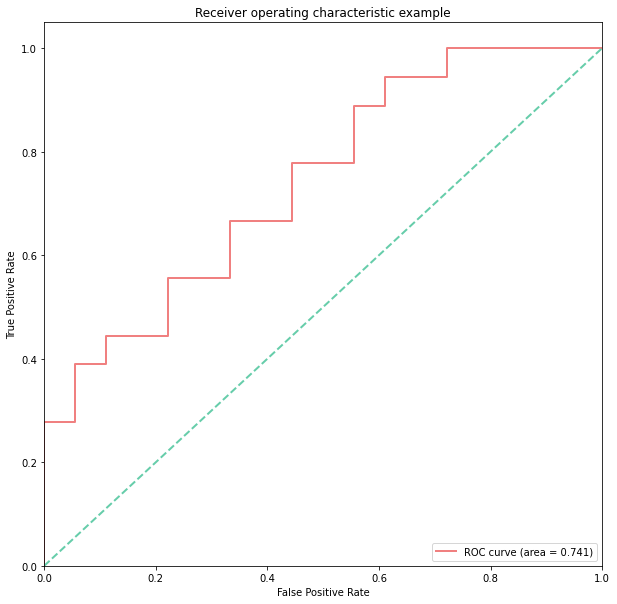

,Accuracy,Recall,Precision
0,0.666667,0.375,0.75


In [31]:
ada_SD_OH = create_model('ada')
et_SD_OH = create_model('et')
nb_SD_OH = create_model('nb')
ada_SD_OH_final = finalize_model(ada_SD_OH)
et_SD_OH_final = finalize_model(et_SD_OH)
nb_SD_OH_final = finalize_model(nb_SD_OH)
blend_SD_OH = blend_models(estimator_list = [ada_SD_OH_final,et_SD_OH_final,nb_SD_OH_final],method = 'soft')
method_SD_OH = getattr(blend_SD_OH,"predict_proba") 
prob_SD_OH = method_SD_OH(data_SD_test_OH[get_config('X_train').columns])
ROC_SD_OH = acu_curve(data_SD_test_OH['Group'],prob_SD_OH,["NonSD", "Slow_Decliner"],'Guangzhou_OTU_HostT_')
stat_table(data_SD_test_OH['Group'],predict_model(blend_SD_OH,data = data_SD_test_OH)['Label'],pos_label = 'Slow_Decliner')

### ST vs NonST

In [32]:
data_ST_train_OH = data_gz_train_OH.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
data_ST_test_OH = data_gz_test_OH.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
ST_group_OH = setup(data_ST_train_OH,target = "Group", session_id = 45,
                    numeric_features = data_gz_train_OH.columns[0:515].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8833,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.0760
xgboost,Extreme Gradient Boosting,0.8833,0.9500,0.8000,0.8000,0.8000,0.8000,0.8000,0.1380
gbc,Gradient Boosting Classifier,0.6667,0.7000,0.6000,0.4000,0.4667,0.3200,0.3500,0.0780
et,Extra Trees Classifier,0.6000,0.5000,0.4000,0.3000,0.3333,0.1800,0.2000,0.1820
qda,Quadratic Discriminant Analysis,0.5833,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0170
lightgbm,Light Gradient Boosting Machine,0.5833,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0280
dt,Decision Tree Classifier,0.5333,0.5250,0.3000,0.2500,0.2667,0.0400,0.0500,0.0140
rf,Random Forest Classifier,0.5333,0.5000,0.2000,0.1500,0.1667,-0.0100,0.0000,0.1610
lda,Linear Discriminant Analysis,0.4667,0.4500,0.3000,0.1833,0.2167,-0.0600,-0.0500,0.0170
lr,Logistic Regression,0.4500,0.4000,0.2000,0.2000,0.2000,-0.1500,-0.1500,0.0240


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=45)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.3333,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

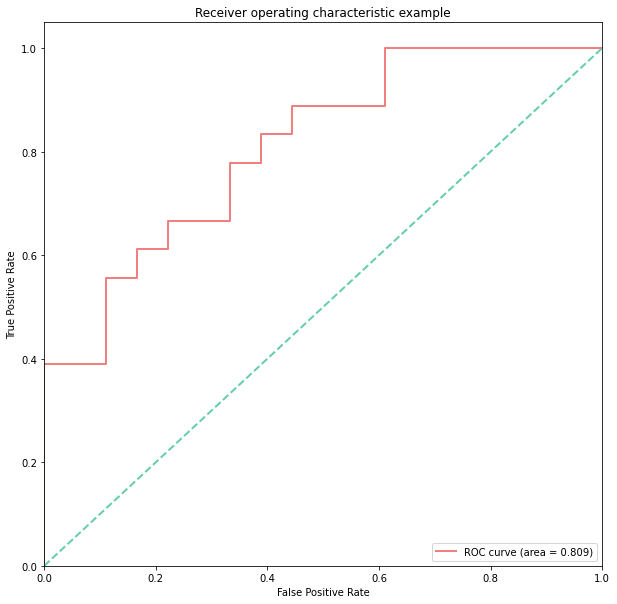

,Accuracy,Recall,Precision
0,0.666667,0.4,0.4


In [33]:
svm_ST_OH_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 45)
ada_ST_OH = create_model('ada')
gbm_ST_OH = create_model('lightgbm')
svm_ST_OH = create_model(svm_ST_OH_temp)
ada_ST_OH_final = finalize_model(ada_ST_OH)
gbm_ST_OH_final = finalize_model(gbm_ST_OH)
svm_ST_OH_final = finalize_model(svm_ST_OH)
blend_ST_OH = blend_models(estimator_list = [ada_ST_OH_final,gbm_ST_OH_final,svm_ST_OH_final],method = 'soft')
method_ST_OH = getattr(blend_ST_OH,"predict_proba") 
prob_ST_OH = method_ST_OH(data_ST_test_OH[get_config('X_train').columns])
ROC_ST_OH = acu_curve(data_ST_test_OH['Group'],prob_ST_OH,["NonST", "Sustainer"],'Guangzhou_OTU_HostT_')
stat_table(data_ST_test_OH['Group'],predict_model(blend_ST_OH,data = data_ST_test_OH)['Label'],pos_label = 'Sustainer')

## 微生物组+代谢组数据

In [34]:
### train-test sample splitting
X_train_OM,X_test_OM,y_train_OM,y_test_OM = train_test_split(data_OTU_Meta,
                                                             data_multi_gz_new[['FEV1_rate','Group']],test_size = 0.3,random_state = 0)
data_gz_train_OM = pd.concat([X_train_OM,y_train_OM],axis=1)
data_gz_test_OM = pd.concat([X_test_OM,y_test_OM],axis=1)

In [35]:
from pycaret.regression import *
setup(data_gz_train_OM, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
    transformation = True,session_id = 42,ignore_features = ['Group'],numeric_features = data_gz_train_OM.columns[0:497].tolist(),silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,24.7253,1404.6771,30.3486,-0.7696,0.8298,1.1943,0.0280
br,Bayesian Ridge,24.8698,1380.9104,29.6895,-0.8241,1.0271,1.1173,0.0180
rf,Random Forest Regressor,25.7880,1468.4548,30.5978,-0.9064,1.0894,1.1207,0.1590
et,Extra Trees Regressor,24.9185,1250.9259,29.0685,-0.9300,0.9083,1.1182,0.1360
ada,AdaBoost Regressor,25.1408,1420.3161,30.3665,-0.9831,0.9834,1.0774,0.0570
en,Elastic Net,23.7073,1327.4350,28.4711,-1.0199,0.8738,1.1254,0.0120
lasso,Lasso Regression,24.6185,1380.4342,28.9729,-1.1190,0.8112,1.3084,0.0120
lr,Linear Regression,23.8513,1322.3489,28.9201,-1.2323,0.9833,1.0806,0.0160
ridge,Ridge Regression,23.7657,1322.3231,28.9350,-1.2366,0.9962,1.0654,0.0110
llar,Lasso Least Angle Regression,28.1064,1639.4953,33.7584,-2.1092,0.8996,1.3882,0.0110


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [36]:
reg_OM = create_model('lightgbm')
tuned_reg_OM = tune_model(finalize_model(reg_OM))
pred_OM = predict_model(tuned_reg_OM,data = data_gz_test_OM)['Label']
pred_train_OM = predict_model(tuned_reg_OM,data = data_gz_train_OM)['Label']
data_gz_test_OM['FEV1_rate'] = pred_OM
data_gz_train_OM['FEV1_rate'] = pred_train_OM

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.0973,6265.9810,79.1579,-0.0349,1.6121,0.7086
1,45.3889,3712.4433,60.9298,-1.2468,1.6752,0.6313
2,23.6086,1081.5607,32.8871,-0.3498,0.6390,0.7409
3,11.1728,260.7656,16.1482,-0.2427,0.1988,0.8007
4,7.6179,79.3082,8.9055,-0.0013,0.7371,1.0678
5,12.6420,225.6487,15.0216,-2.4278,0.6448,1.6730
6,9.7091,127.8504,11.3071,-2.8069,0.8809,2.3979
7,19.3942,583.1195,24.1479,-0.5503,0.2725,1.0056
8,37.3500,1403.0014,37.4567,-0.0057,0.9638,1.1162
9,17.2727,307.0923,17.5240,-0.0293,0.6732,1.8010


### RD vs NonRD

In [37]:
from pycaret.classification import *
data_RD_train_OM = data_gz_train_OM.replace(["Slow_Decliner","Sustainer"],"NonRD")
data_RD_test_OM = data_gz_test_OM.replace(["Slow_Decliner","Sustainer"],"NonRD")
RD_group_OM = setup(data_RD_train_OM,target = "Group", session_id = 43,
                    numeric_features = data_gz_train_OM.columns[0:497].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8333,0.2000,0.0000,0.0000,0.0000,nan,0.0000,0.0300
knn,K Neighbors Classifier,0.8333,0.2750,0.0000,0.0000,0.0000,nan,0.0000,0.0250
svm,SVM - Linear Kernel,0.8333,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0110
ridge,Ridge Classifier,0.8333,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0100
rf,Random Forest Classifier,0.8333,0.4250,0.0000,0.0000,0.0000,nan,0.0000,0.2130
qda,Quadratic Discriminant Analysis,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0340
ada,Ada Boost Classifier,0.8333,0.3750,0.1000,0.0500,0.0667,nan,0.0500,0.1540
et,Extra Trees Classifier,0.8333,0.2000,0.0000,0.0000,0.0000,nan,0.0000,0.2050
lightgbm,Light Gradient Boosting Machine,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0310
xgboost,Extreme Gradient Boosting,0.8167,0.3000,0.1000,0.1000,0.1000,nan,0.1000,0.2800


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=43, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


<Figure size 432x288 with 0 Axes>

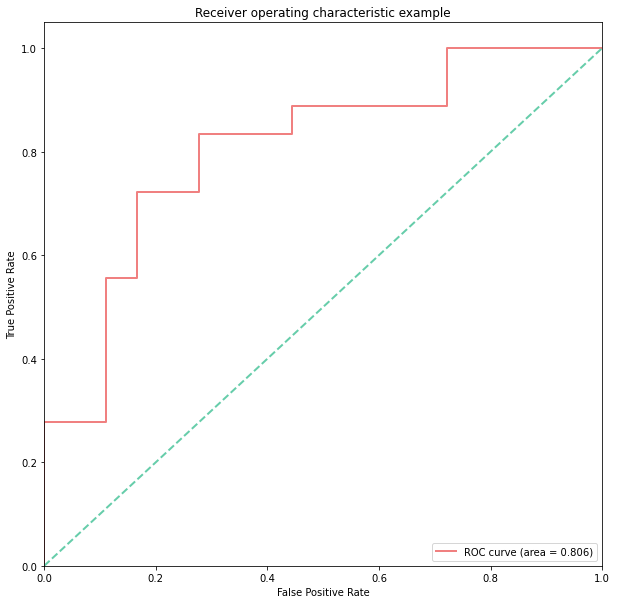

,Accuracy,Recall,Precision
0,0.722222,0.0,0.0


In [38]:
lr_RD_OM = create_model('lr')
knn_RD_OM = create_model('knn')
qda_RD_OM = create_model('qda')
lr_RD_OM_final = finalize_model(lr_RD_OM)
knn_RD_OM_final = finalize_model(knn_RD_OM)
qda_RD_OM_final = finalize_model(qda_RD_OM)
blend_RD_OM = blend_models(estimator_list = [lr_RD_OM_final,knn_RD_OM_final,qda_RD_OM_final],method = 'soft')
method_RD_OM = getattr(blend_RD_OM,"predict_proba") 
prob_RD_OM = method_RD_OM(data_RD_test_OM[get_config('X_train').columns])
ROC_RD_OM = acu_curve(data_RD_test_OM['Group'],prob_RD_OM,["NonRD", "Rapid_Decliner"],'Guangzhou_OTU_MetaB_')
stat_table(data_RD_test_OM['Group'],predict_model(blend_RD_OM,data = data_RD_test_OM)['Label'],pos_label = 'Rapid_Decliner')

### SD vs NonSD

In [39]:
data_SD_train_OM = data_gz_train_OM.replace(["Rapid_Decliner","Sustainer"],"NonSD")
data_SD_test_OM = data_gz_test_OM.replace(["Rapid_Decliner","Sustainer"],"NonSD")
SD_group_OM = setup(data_SD_train_OM,target = "Group", session_id = 44,
                    numeric_features = data_gz_train_OM.columns[0:497].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6167,0.6500,0.3000,0.2500,0.2667,0.0900,0.1000,0.0220
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0690
qda,Quadratic Discriminant Analysis,0.5833,0.4750,0.0000,0.0000,0.0000,-0.0500,-0.0500,0.0310
xgboost,Extreme Gradient Boosting,0.5833,0.6500,0.2000,0.1500,0.1667,0.0200,0.0000,0.4660
dt,Decision Tree Classifier,0.5667,0.5000,0.3000,0.2000,0.2333,-0.0100,0.0000,0.0160
rf,Random Forest Classifier,0.5500,0.6000,0.2000,0.1000,0.1333,-0.0400,-0.0500,0.1880
ada,Ada Boost Classifier,0.5500,0.4500,0.3000,0.2000,0.2333,-0.0300,-0.0500,0.1630
gbc,Gradient Boosting Classifier,0.5333,0.2500,0.2000,0.1500,0.1667,-0.0800,-0.1000,0.1760
et,Extra Trees Classifier,0.5000,0.5250,0.2000,0.1000,0.1333,-0.1400,-0.1500,0.2470
knn,K Neighbors Classifier,0.4667,0.3750,0.1000,0.0500,0.0667,-0.2100,-0.2000,0.0230


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
1,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,0.2500,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,-1.0000
8,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

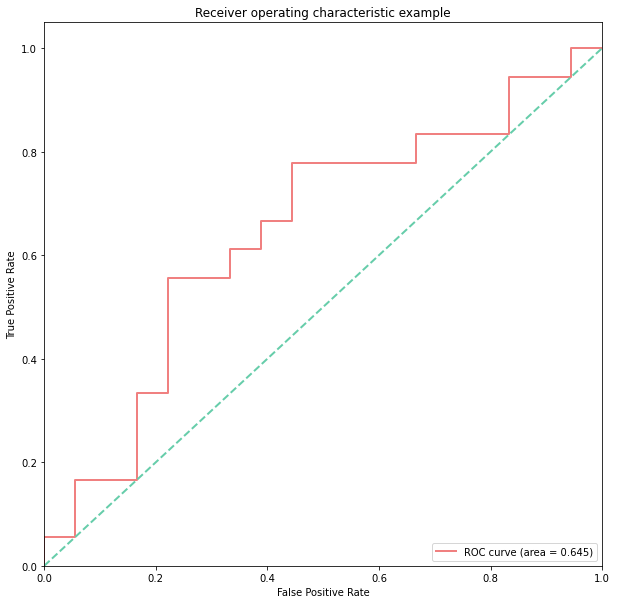

,Accuracy,Recall,Precision
0,0.611111,0.125,1.0


In [40]:
lda_SD_OM = create_model('lda')
gbm_SD_OM = create_model('lightgbm')
dt_SD_OM = create_model('dt')
lda_SD_OM_final = finalize_model(lda_SD_OM)
gbm_SD_OM_final = finalize_model(gbm_SD_OM)
dt_SD_OM_final = finalize_model(dt_SD_OM)
blend_SD_OM = blend_models(estimator_list = [tune_model(lda_SD_OM_final),gbm_SD_OM_final,dt_SD_OM_final],method = 'soft')
method_SD_OM = getattr(blend_SD_OM,"predict_proba") 
prob_SD_OM = method_SD_OM(data_SD_test_OM[get_config('X_train').columns])
ROC_SD_OM = acu_curve(data_SD_test_OM['Group'],prob_SD_OM,["NonSD", "Slow_Decliner"],'Guangzhou_OTU_MetaB_')
stat_table(data_SD_test_OM['Group'],predict_model(blend_SD_OM,data = data_SD_test_OM)['Label'],pos_label = 'Slow_Decliner')

### ST vs NonST

In [41]:
data_ST_train_OM = data_gz_train_OM.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
data_ST_test_OM = data_gz_test_OM.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
ST_group_OM = setup(data_ST_train_OM,target = "Group", session_id = 45,
                    numeric_features = data_gz_train_OM.columns[0:497].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.6333,0.6000,0.5000,0.3500,0.4000,0.2700,0.3000,0.1170
xgboost,Extreme Gradient Boosting,0.6000,0.6500,0.4000,0.3000,0.3333,0.1800,0.2000,0.1460
lightgbm,Light Gradient Boosting Machine,0.5833,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0570
et,Extra Trees Classifier,0.5500,0.7000,0.2000,0.1500,0.1667,-0.0100,0.0000,0.1810
qda,Quadratic Discriminant Analysis,0.5167,0.4500,0.0000,0.0000,0.0000,-0.0800,-0.1000,0.0290
dt,Decision Tree Classifier,0.5000,0.5000,0.4000,0.3000,0.3333,0.0100,0.0000,0.0130
rf,Random Forest Classifier,0.5000,0.5500,0.1000,0.0500,0.0667,-0.1100,-0.1000,0.4000
lda,Linear Discriminant Analysis,0.5000,0.3500,0.2000,0.1000,0.1333,-0.0700,-0.0500,0.0190
gbc,Gradient Boosting Classifier,0.4833,0.5750,0.4000,0.2833,0.3167,-0.0100,0.0000,0.1140
lr,Logistic Regression,0.4500,0.3500,0.2000,0.2000,0.2000,-0.1500,-0.1500,0.0180


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=45)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.3333,0.0000,0.0000,0.0000,0.0000,-0.5000,-0.5000
4,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.3333,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<Figure size 432x288 with 0 Axes>

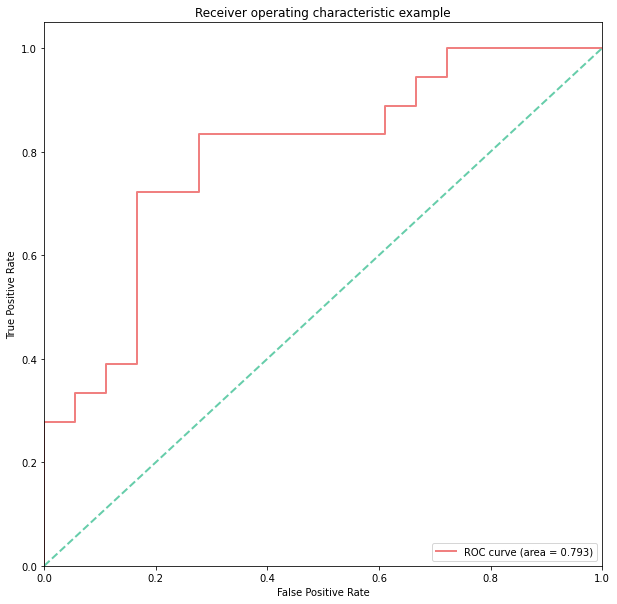

,Accuracy,Recall,Precision
0,0.722222,0.2,0.5


In [42]:
svm_ST_OM_temp = svm.SVC(kernel = 'linear', probability = True, random_state = 45)
svm_ST_OM = create_model(svm_ST_OM_temp)
rf_ST_OM = create_model('rf')
gbm_ST_OM = create_model('lightgbm')
svm_ST_OM_final = finalize_model(svm_ST_OM)
rf_ST_OM_final = finalize_model(rf_ST_OM)
gbm_ST_OM_final = finalize_model(gbm_ST_OM)
blend_ST_OM = blend_models(estimator_list = [svm_ST_OM_final,rf_ST_OM_final,tune_model(gbm_ST_OM_final)],method = 'soft')
method_ST_OM = getattr(blend_ST_OM,"predict_proba") 
prob_ST_OM = method_ST_OM(data_ST_test_OM[get_config('X_train').columns])
ROC_ST_OM = acu_curve(data_ST_test_OM['Group'],prob_ST_OM,["NonST", "Sustainer"],'Guangzhou_OTU_MetaB_')
stat_table(data_ST_test_OM['Group'],predict_model(blend_ST_OM,data = data_ST_test_OM)['Label'],pos_label = 'Sustainer')

## 转录组+代谢组数据

In [43]:
### train-test sample splitting
X_train_HM,X_test_HM,y_train_HM,y_test_HM = train_test_split(data_Host_Meta,
                                                             data_multi_gz_new[['FEV1_rate','Group']],test_size = 0.3,random_state = 0)
data_gz_train_HM = pd.concat([X_train_HM,y_train_HM],axis=1)
data_gz_test_HM = pd.concat([X_test_HM,y_test_HM],axis=1)

In [44]:
from pycaret.regression import *
setup(data_gz_train_HM, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
      transformation = True,session_id = 42,ignore_features = ['Group'],numeric_features = data_gz_train_HM.columns[0:319].tolist(),silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,24.6378,1537.7400,30.3681,-0.6758,0.9684,0.9417,0.1800
lightgbm,Light Gradient Boosting Machine,24.7253,1404.6771,30.3486,-0.7696,0.8298,1.1943,0.0160
et,Extra Trees Regressor,22.6907,1345.6450,28.1305,-0.8637,1.0451,0.9367,0.1350
knn,K Neighbors Regressor,26.9100,1512.1786,31.6892,-1.4840,1.5822,1.3182,0.0130
llar,Lasso Least Angle Regression,23.6967,1393.8875,29.5414,-1.6514,0.9459,1.3185,0.0170
br,Bayesian Ridge,26.1745,1575.8438,31.4214,-1.7403,1.1081,1.3776,0.0150
ada,AdaBoost Regressor,26.1827,1489.0515,31.9464,-2.0997,1.1686,1.3592,0.0570
gbr,Gradient Boosting Regressor,28.0207,1809.2741,33.6874,-2.3309,1.1476,1.3753,0.0320
en,Elastic Net,27.6125,1551.9023,32.6229,-2.6096,1.2581,1.5203,0.0180
xgboost,Extreme Gradient Boosting,31.0148,2279.5368,38.8458,-3.7810,1.1559,1.4477,0.1370


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [45]:
reg_HM = create_model('ada')
tuned_reg_HM = tune_model(finalize_model(reg_HM))
pred_HM = predict_model(tuned_reg_HM,data = data_gz_test_HM)['Label']
pred_train_HM = predict_model(tuned_reg_HM,data = data_gz_train_HM)['Label']
data_gz_test_HM['FEV1_rate'] = pred_HM
data_gz_train_HM['FEV1_rate'] = pred_train_HM

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.2468,6275.5693,79.2185,-0.0365,1.6261,0.7191
1,47.9206,4440.9831,66.6407,-1.6878,2.0268,0.6278
2,24.8361,1090.6396,33.0248,-0.3612,0.8031,0.7744
3,11.2248,196.9100,14.0325,0.0616,0.3971,0.7694
4,15.1045,419.2298,20.4751,-4.2928,0.7577,1.0441
5,8.0825,120.5383,10.9790,-0.8311,0.3164,1.0207
6,5.9239,43.5126,6.5964,-0.2956,0.6309,1.0218
7,20.9405,524.2701,22.8969,-0.3938,0.7018,1.0833
8,35.0618,1230.0033,35.0714,0.1183,1.0877,1.0322
9,16.3429,267.1265,16.3440,0.1046,0.6342,1.5512


### RD vs NonRD

In [46]:
from pycaret.classification import *
data_RD_train_HM = data_gz_train_HM.replace(["Slow_Decliner","Sustainer"],"NonRD")
data_RD_test_HM = data_gz_test_HM.replace(["Slow_Decliner","Sustainer"],"NonRD")
RD_group_HM = setup(data_RD_train_HM,target = "Group", session_id = 43,
                    numeric_features = data_gz_train_HM.columns[0:320].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9167,0.5000,0.4000,0.4000,0.4000,nan,0.4000,0.0390
nb,Naive Bayes,0.8667,0.3500,0.1000,0.1000,0.1000,nan,0.1000,0.0170
lr,Logistic Regression,0.8333,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.0290
ridge,Ridge Classifier,0.8333,0.0000,0.1000,0.1000,0.1000,nan,0.0500,0.0110
qda,Quadratic Discriminant Analysis,0.8333,0.3000,0.2000,0.1333,0.1500,nan,0.1000,0.0150
ada,Ada Boost Classifier,0.8333,0.3500,0.1000,0.0500,0.0667,nan,0.0500,0.0930
et,Extra Trees Classifier,0.8333,0.4000,0.1000,0.1000,0.1000,nan,0.0500,0.2450
xgboost,Extreme Gradient Boosting,0.8333,0.2000,0.1000,0.1000,0.1000,nan,0.0500,0.2180
lightgbm,Light Gradient Boosting Machine,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0330
rf,Random Forest Classifier,0.8000,0.1750,0.0000,0.0000,0.0000,nan,-0.0500,0.2990


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                     weights='uniform')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
2,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


<Figure size 432x288 with 0 Axes>

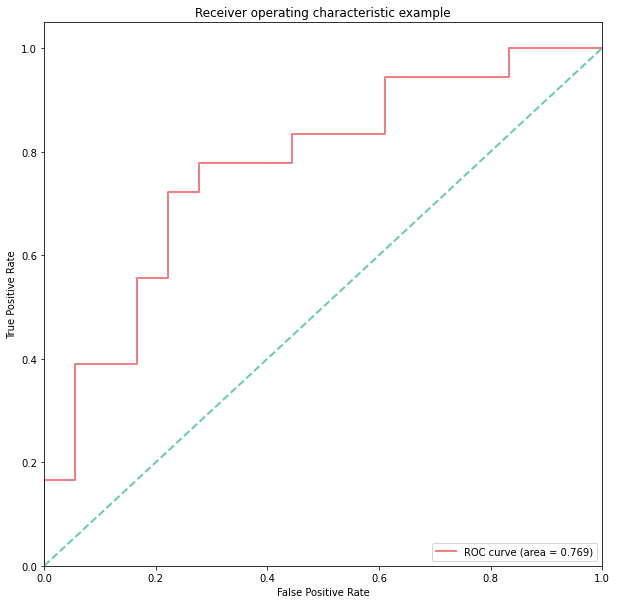

,Accuracy,Recall,Precision
0,0.722222,0.6,0.5


In [47]:
gbm_RD_HM = create_model('lightgbm')
knn_RD_HM = create_model('knn')
qda_RD_HM = create_model('qda')
gbm_RD_HM_final = finalize_model(gbm_RD_HM)
knn_RD_HM_final = finalize_model(knn_RD_HM)
qda_RD_HM_final = finalize_model(qda_RD_HM)
blend_RD_HM = blend_models(estimator_list = [gbm_RD_HM_final,knn_RD_HM_final,tune_model(qda_RD_HM_final)],method = 'soft')
method_RD_HM = getattr(blend_RD_HM,"predict_proba") 
prob_RD_HM = method_RD_HM(data_RD_test_HM[get_config('X_train').columns])
ROC_RD_HM = acu_curve(data_RD_test_HM['Group'],prob_RD_HM,["NonRD", "Rapid_Decliner"],'Guangzhou_HostT_MetaB_')
stat_table(data_RD_test_HM['Group'],predict_model(blend_RD_HM,data = data_RD_test_HM)['Label'],pos_label = 'Rapid_Decliner')

### SD vs NonSD

In [48]:
data_SD_train_HM = data_gz_train_HM.replace(["Rapid_Decliner","Sustainer"],"NonSD")
data_SD_test_HM = data_gz_test_HM.replace(["Rapid_Decliner","Sustainer"],"NonSD")
SD_group_HM = setup(data_SD_train_HM,target = "Group", session_id = 44,
                    numeric_features = data_gz_train_HM.columns[0:320].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8167,0.9000,0.7000,0.7000,0.7000,0.6200,0.6000,0.0160
lr,Logistic Regression,0.7500,0.8500,0.6000,0.5500,0.5667,0.4400,0.4500,0.0250
nb,Naive Bayes,0.7500,0.8750,0.7000,0.6000,0.6333,0.5000,0.5000,0.0150
et,Extra Trees Classifier,0.7167,0.9000,0.5000,0.4500,0.4667,0.3600,0.3500,0.1460
ridge,Ridge Classifier,0.7000,0.0000,0.7000,0.5000,0.5667,0.3700,0.4000,0.0130
rf,Random Forest Classifier,0.6833,0.8000,0.4000,0.3500,0.3667,0.2600,0.2500,0.1800
ada,Ada Boost Classifier,0.6833,0.6750,0.4000,0.3500,0.3667,0.2600,0.2500,0.1120
xgboost,Extreme Gradient Boosting,0.6833,0.7500,0.5000,0.4500,0.4667,0.3100,0.3000,0.1540
qda,Quadratic Discriminant Analysis,0.6667,0.6250,0.5000,0.4000,0.4333,0.2600,0.2500,0.0150
knn,K Neighbors Classifier,0.6500,0.7000,0.6000,0.4333,0.4833,0.2800,0.3000,0.0270


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
1,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,0.5000,1.0000,0.5000,0.6667,0.4000,0.5000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.3333,0.5000,0.0000,0.0000,0.0000,-0.5000,-0.5000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

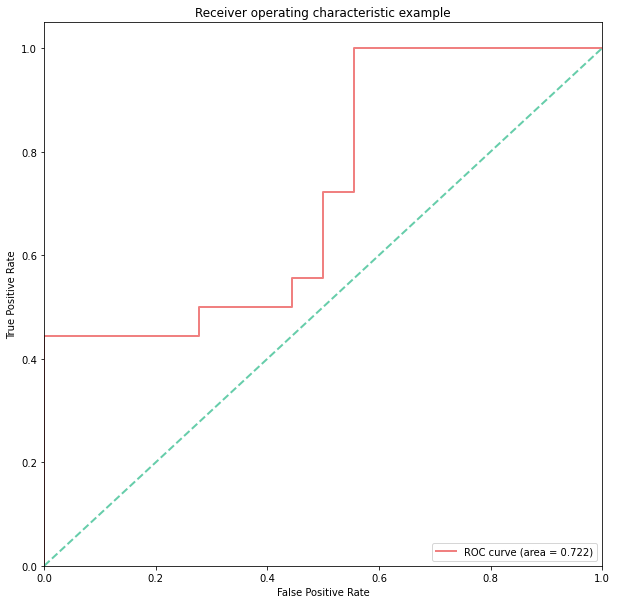

,Accuracy,Recall,Precision
0,0.555556,0.375,0.5


In [49]:
lr_SD_HM = create_model('lr')
knn_SD_HM = create_model('knn')
lda_SD_HM = create_model('lda')
lr_SD_HM_final = finalize_model(lr_SD_HM)
knn_SD_HM_final = finalize_model(knn_SD_HM)
lda_SD_HM_final = finalize_model(lda_SD_HM)
blend_SD_HM = blend_models(estimator_list = [lr_SD_HM_final,knn_SD_HM_final,tune_model(lda_SD_HM_final)],method = 'soft')
method_SD_HM = getattr(blend_SD_HM,"predict_proba") 
prob_SD_HM = method_SD_HM(data_SD_test_HM[get_config('X_train').columns])
ROC_SD_HM = acu_curve(data_SD_test_HM['Group'],prob_SD_HM,["NonSD", "Slow_Decliner"],'Guangzhou_HostT_MetaB_')
stat_table(data_SD_test_HM['Group'],predict_model(blend_SD_HM,data = data_SD_test_HM)['Label'],pos_label = 'Slow_Decliner')

### ST vs NonST

In [50]:
data_ST_train_HM = data_gz_train_HM.replace(["Slow_Decliner","Rapid_Decliner"],"NonST")
data_ST_test_HM = data_gz_test_HM.replace(["Slow_Decliner","Rapid_Decliner"],"NonST")
ST_group_HM = setup(data_ST_train_HM,target = "Group", session_id = 45,
                    numeric_features = data_gz_train_HM.columns[0:320].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8167,0.7000,0.6000,0.5500,0.5667,0.5400,0.5500,0.0170
knn,K Neighbors Classifier,0.8167,0.7000,0.6000,0.5500,0.5667,0.5400,0.5500,0.0360
svm,SVM - Linear Kernel,0.7667,0.0000,0.4000,0.4000,0.4000,0.4000,0.4000,0.0190
dt,Decision Tree Classifier,0.7333,0.7500,0.7000,0.5500,0.6000,0.4800,0.5000,0.0270
gbc,Gradient Boosting Classifier,0.7333,0.7000,0.6000,0.5000,0.5333,0.4400,0.4500,0.1650
ada,Ada Boost Classifier,0.6667,0.7000,0.6000,0.4333,0.4833,0.3400,0.3500,0.1170
et,Extra Trees Classifier,0.6500,0.6250,0.4000,0.3000,0.3333,0.2400,0.2500,0.5780
xgboost,Extreme Gradient Boosting,0.6333,0.7000,0.4500,0.4000,0.4000,0.1800,0.2000,0.1960
nb,Naive Bayes,0.6000,0.5500,0.6000,0.4000,0.4667,0.2200,0.2500,0.0210
rf,Random Forest Classifier,0.5833,0.6000,0.4000,0.3000,0.3333,0.1400,0.1500,0.4080


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=45, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,1.0000,1.0000,0.5000,0.6667,0.4000,0.5000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

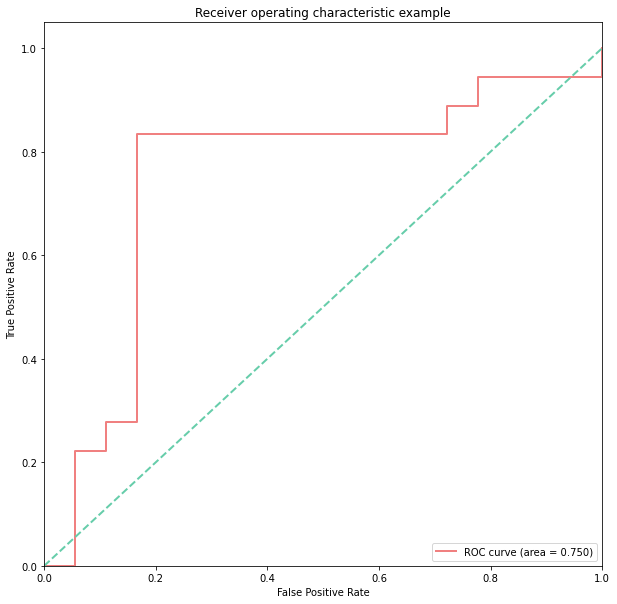

,Accuracy,Recall,Precision
0,0.833333,0.4,1.0


In [51]:
lr_ST_HM = create_model('lr')
knn_ST_HM = create_model('knn')
gbc_ST_HM = create_model('gbc')
lr_ST_HM_final = finalize_model(lr_ST_HM)
knn_ST_HM_final = finalize_model(knn_ST_HM)
gbc_ST_HM_final = finalize_model(gbc_ST_HM)
blend_ST_HM = blend_models(estimator_list = [lr_ST_HM_final,knn_ST_HM_final,tune_model(gbc_ST_HM_final)],method = 'soft')
method_ST_HM = getattr(blend_ST_HM,"predict_proba") 
prob_ST_HM = method_ST_HM(data_ST_test_HM[get_config('X_train').columns])
ROC_ST_HM = acu_curve(data_ST_test_HM['Group'],prob_ST_HM,["NonST", "Sustainer"],'Guangzhou_HostT_MetaB_')
stat_table(data_ST_test_HM['Group'],predict_model(blend_ST_HM,data = data_ST_test_HM)['Label'],pos_label = 'Sustainer')

## 微生物组+转录组+代谢组数据

In [52]:
X_train_all,X_test_all,y_train_all,y_test_all = train_test_split(data_multi_gz_new.drop(axis = 1,columns = ['FEV1_rate','Group']),
                                                             data_multi_gz_new[['FEV1_rate','Group']],test_size = 0.3,random_state = 0)
data_gz_train_all = pd.concat([X_train_all,y_train_all],axis=1)
data_gz_test_all = pd.concat([X_test_all,y_test_all],axis=1)

In [53]:
from pycaret.regression import *
setup(data_gz_train_all, target = 'FEV1_rate',remove_multicollinearity = True, multicollinearity_threshold = 0.7,
        transformation = True,session_id = 42,ignore_features = ['Group'],numeric_features = data_gz_train_all.columns[0:666].tolist(),silent = True)
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,24.3891,1458.2344,29.6024,-0.5131,1.3016,0.9793,0.0490
lightgbm,Light Gradient Boosting Machine,24.7253,1404.6771,30.3486,-0.7696,0.8298,1.1943,0.0340
rf,Random Forest Regressor,24.9533,1400.0341,30.2578,-0.9367,0.9892,1.1463,0.3260
et,Extra Trees Regressor,24.7388,1275.7741,29.4488,-0.9928,1.0930,1.1037,0.1820
ada,AdaBoost Regressor,25.2205,1399.0168,30.5641,-1.0540,0.7833,1.0802,0.1340
br,Bayesian Ridge,25.1595,1414.8503,30.2716,-1.1122,1.1813,1.1688,0.0440
en,Elastic Net,23.6806,1393.0113,28.9524,-1.1750,1.1084,1.1256,0.0160
lasso,Lasso Regression,28.8625,1847.9656,34.0779,-1.4016,0.9174,1.2158,0.0170
ridge,Ridge Regression,23.6654,1419.3979,29.3704,-1.5480,1.2523,1.0899,0.0150
lr,Linear Regression,23.8649,1430.4457,29.5061,-1.5752,1.2661,1.1017,0.0180


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
                    weights='uniform')

In [54]:
reg_all = create_model('ada')
tuned_reg_all = tune_model(finalize_model(reg_all))
pred_all = predict_model(tuned_reg_all,data = data_gz_test_all)['Label']
pred_train_all = predict_model(tuned_reg_all,data = data_gz_train_all)['Label']
data_gz_test_all['FEV1_rate'] = pred_all
data_gz_train_all['FEV1_rate'] = pred_train_all

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,63.4169,6275.7528,79.2196,-0.0365,1.6629,0.7379
1,44.3400,3641.6618,60.3462,-1.2040,1.5974,0.5882
2,23.3516,1009.5096,31.7728,-0.2599,0.8704,0.6810
3,12.5407,224.9593,14.9986,-0.0721,0.3968,0.8694
4,15.5903,426.7822,20.6587,-4.3882,0.7967,1.1638
5,9.1693,137.2804,11.7167,-1.0854,0.4761,1.0655
6,8.9885,107.8973,10.3874,-2.2128,0.8185,2.1761
7,25.8303,687.3030,26.2165,-0.8273,1.4538,1.3336
8,37.0412,1372.7824,37.0511,0.0159,1.0963,1.0904
9,16.2602,264.6048,16.2667,0.1131,0.6220,1.5594


### RD vs NonRD

In [55]:
from pycaret.classification import *
data_RD_train_all = data_gz_train_all.replace(["Slow_Decliner","Sustainer"],"NonRD")
data_RD_test_all = data_gz_test_all.replace(["Slow_Decliner","Sustainer"],"NonRD")
RD_group_all = setup(data_RD_train_all,target = "Group", session_id = 43,
                    numeric_features = data_gz_train_all.columns[0:666].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8667,0.2750,0.1000,0.1000,0.1000,nan,0.1000,0.1310
lr,Logistic Regression,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0300
knn,K Neighbors Classifier,0.8333,0.2250,0.0000,0.0000,0.0000,nan,0.0000,0.0370
ridge,Ridge Classifier,0.8333,0.0000,0.0000,0.0000,0.0000,nan,0.0000,0.0270
rf,Random Forest Classifier,0.8333,0.3500,0.0000,0.0000,0.0000,nan,0.0000,0.3000
et,Extra Trees Classifier,0.8333,0.3750,0.0000,0.0000,0.0000,nan,0.0000,0.2060
lightgbm,Light Gradient Boosting Machine,0.8333,0.2500,0.0000,0.0000,0.0000,nan,0.0000,0.0540
qda,Quadratic Discriminant Analysis,0.8000,0.2750,0.1000,0.1000,0.1000,nan,0.0500,0.0330
lda,Linear Discriminant Analysis,0.8000,0.1000,0.0000,0.0000,0.0000,nan,0.0000,0.0420
xgboost,Extreme Gradient Boosting,0.8000,0.2500,0.0000,0.0000,0.0000,nan,-0.0500,0.3500


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=43)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
1,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
8,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000
9,1.0000,0.0000,0.0000,0.0000,0.0000,nan,0.0000


<Figure size 432x288 with 0 Axes>

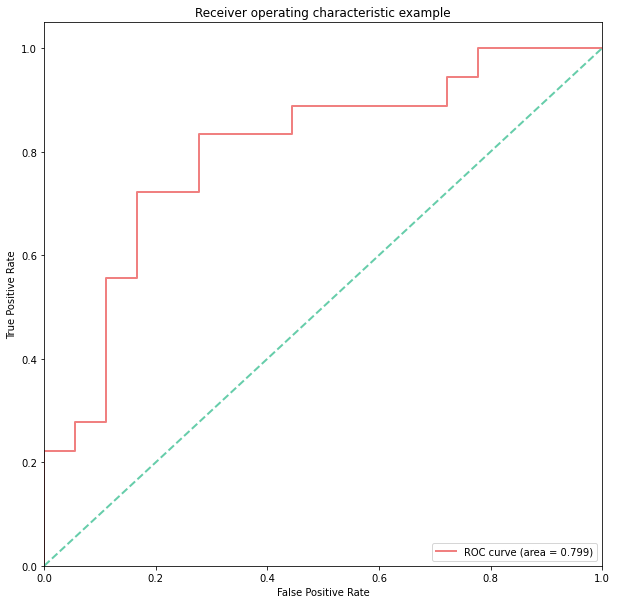

,Accuracy,Recall,Precision
0,0.722222,0.4,0.5


In [56]:
lr_RD_all = create_model('lr')
knn_RD_all = create_model('knn')
qda_RD_all = create_model('qda')
lr_RD_all_final = finalize_model(lr_RD_all)
knn_RD_all_final = finalize_model(knn_RD_all)
qda_RD_all_final = finalize_model(qda_RD_all)
blend_RD_all = blend_models(estimator_list = [lr_RD_all_final,knn_RD_all_final,tune_model(qda_RD_all_final)],method = 'soft')
method_RD_all = getattr(blend_RD_all,"predict_proba") 
prob_RD_all = method_RD_all(data_RD_test_all[get_config('X_train').columns])
ROC_RD_all = acu_curve(data_RD_test_all['Group'],prob_RD_all,["NonRD", "Rapid_Decliner"],'Guangzhou_OTU_HostT_MetaB_')
stat_table(data_RD_test_all['Group'],predict_model(blend_RD_all,data = data_RD_test_all)['Label'],pos_label = 'Rapid_Decliner')

### SD vs NonSD

In [57]:
data_SD_train_all = data_gz_train_all.replace(["Rapid_Decliner","Sustainer"],"NonSD")
data_SD_test_all = data_gz_test_all.replace(["Rapid_Decliner","Sustainer"],"NonSD")
SD_group_all = setup(data_SD_train_all,target = "Group", session_id = 44,
                    numeric_features = data_gz_train_all.columns[0:666].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8000,0.8500,0.7000,0.6500,0.6667,0.5600,0.5500,0.0180
rf,Random Forest Classifier,0.7500,0.9000,0.5000,0.5000,0.5000,0.4200,0.4000,0.1730
et,Extra Trees Classifier,0.7167,0.8000,0.4000,0.4000,0.4000,0.3200,0.3000,0.1760
xgboost,Extreme Gradient Boosting,0.6500,0.8500,0.4000,0.3500,0.3667,0.2100,0.2000,0.1840
knn,K Neighbors Classifier,0.6333,0.6250,0.2000,0.1500,0.1667,0.0900,0.1000,0.0240
lr,Logistic Regression,0.6167,0.5500,0.3000,0.3000,0.3000,0.1200,0.1000,0.0230
lightgbm,Light Gradient Boosting Machine,0.6167,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370
ada,Ada Boost Classifier,0.6000,0.6500,0.5000,0.3500,0.4000,0.1500,0.1500,0.1010
svm,SVM - Linear Kernel,0.5333,0.0000,0.8000,0.4333,0.5500,0.1300,0.1500,0.0130
qda,Quadratic Discriminant Analysis,0.5333,0.5250,0.5000,0.3333,0.3833,0.0300,0.0500,0.0210


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.6667,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.6667,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.6667,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.5000,0.0000,1.0000,0.5000,0.6667,0.0000,0.0000
8,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
9,0.0000,0.0000,0.0000,0.0000,0.0000,-1.0000,-1.0000


<Figure size 432x288 with 0 Axes>

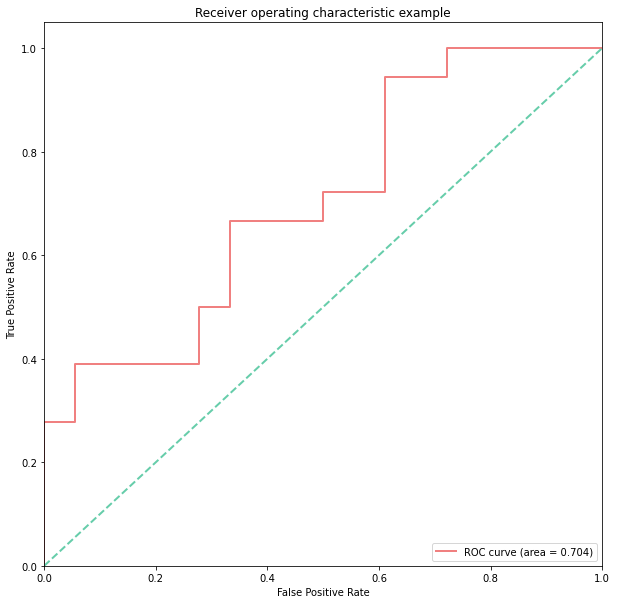

,Accuracy,Recall,Precision
0,0.666667,0.375,0.75


In [58]:
lda_SD_all = create_model('lda')
et_SD_all = create_model('et')
nb_SD_all = create_model('nb')
lda_SD_all_final = finalize_model(lda_SD_all)
et_SD_all_final = finalize_model(et_SD_all)
nb_SD_all_final = finalize_model(nb_SD_all)
blend_SD_all = blend_models(estimator_list = [lda_SD_all_final,et_SD_all_final,nb_SD_all_final],method = 'soft')
method_SD_all = getattr(blend_SD_all,"predict_proba") 
prob_SD_all = method_SD_all(data_SD_test_all[get_config('X_train').columns])
ROC_SD_all = acu_curve(data_SD_test_all['Group'],prob_SD_all,["NonSD", "Slow_Decliner"],'Guangzhou_OTU_HostT_MetaB_')
stat_table(data_SD_test_all['Group'],predict_model(blend_SD_all,data = data_SD_test_all)['Label'],pos_label = 'Slow_Decliner')

### ST vs NonST

In [59]:
data_ST_train_all = data_gz_train_all.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
data_ST_test_all = data_gz_test_all.replace(["Rapid_Decliner","Slow_Decliner"],"NonST")
ST_group_all = setup(data_ST_train_all,target = "Group", session_id = 45,
                    numeric_features = data_gz_train_all.columns[0:666].tolist(),silent = True)
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ada,Ada Boost Classifier,0.8500,0.9500,0.8000,0.7500,0.7667,0.7400,0.7500,0.2080
knn,K Neighbors Classifier,0.7500,0.6750,0.4000,0.4000,0.4000,0.3500,0.3500,0.0370
xgboost,Extreme Gradient Boosting,0.7500,0.9500,0.6000,0.5000,0.5333,0.4800,0.5000,0.2390
gbc,Gradient Boosting Classifier,0.7333,0.7750,0.7000,0.5500,0.6000,0.4800,0.5000,0.1980
lr,Logistic Regression,0.7000,0.5500,0.5000,0.4500,0.4667,0.3400,0.3500,0.0290
dt,Decision Tree Classifier,0.6167,0.6000,0.5000,0.3000,0.3667,0.1800,0.2000,0.0210
svm,SVM - Linear Kernel,0.6000,0.0000,0.4000,0.3000,0.3333,0.1300,0.1500,0.0210
lightgbm,Light Gradient Boosting Machine,0.5833,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0950
et,Extra Trees Classifier,0.5667,0.6000,0.3000,0.2500,0.2667,0.0900,0.1000,0.2430
ridge,Ridge Classifier,0.5167,0.0000,0.3500,0.3500,0.3333,-0.0200,0.0000,0.0240


AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=45)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.6667,0.5000,1.0000,0.5000,0.6667,0.4000,0.5000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.3333,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.5000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


<Figure size 432x288 with 0 Axes>

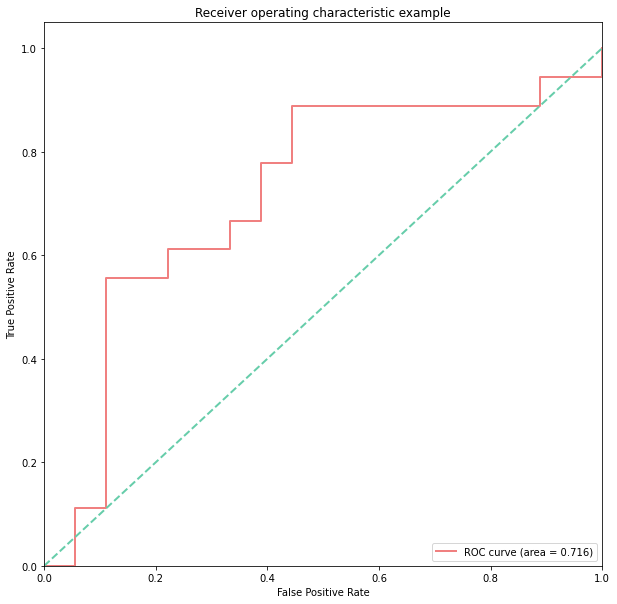

,Accuracy,Recall,Precision
0,0.666667,0.4,0.4


In [60]:
ada_ST_all = create_model('ada')
knn_ST_all = create_model('knn')
gbm_ST_all = create_model('lightgbm')
ada_ST_all_final = finalize_model(ada_ST_all)
knn_ST_all_final = finalize_model(knn_ST_all)
gbm_ST_all_final = finalize_model(gbm_ST_all)
blend_ST_all = blend_models(estimator_list = [ada_ST_all_final,knn_ST_all_final,gbm_ST_all_final],method = 'soft')
method_ST_all = getattr(blend_ST_all,"predict_proba") 
prob_ST_all = method_ST_all(data_ST_test_all[get_config('X_train').columns])
ROC_ST_all = acu_curve(data_ST_test_all['Group'],prob_ST_all,["NonST", "Sustainer"],'Guangzhou_OTU_HostT_MetaB_')
stat_table(data_ST_test_all['Group'],predict_model(blend_ST_all,data = data_ST_test_all)['Label'],pos_label = 'Sustainer')